In [2]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import networkx as nx
import sys
sys.path.insert(0, 'utils/')
from GR_Maze_Utils import *
from GR_RL_Utils import *
import matplotlib.cm as cm
import matplotlib
from matplotlib import rc
rc('text', usetex=False)
matplotlib.rcParams['font.sans-serif'] = ['Arial']


%load_ext autoreload
%autoreload 2

In [3]:
def numberToBase(n, b):
    if n == 0:
        return [0]
    digits = []
    while n:
        digits.append(int(n % b))
        n //= b
    return digits[::-1]

def create_tree_directed(levels, degree):
    G = nx.DiGraph()
    G.add_nodes_from([('r')])
    index = 0
    for l in range(1,levels+1):
        for i in range(degree**l):
            bin_i = bin(i)[2:].zfill(l)
            ter_i = (''.join([str(k) for k in numberToBase(i,degree)])).zfill(l)
            #print(i,bin_i,ter_i)
            G.add_nodes_from([('r'+ ter_i[::-1])])
    edges = []
    for i in range(degree):
        edges += [('r','r%d'%i)]
    for i in list(G.nodes):
        for j in list(G.nodes):
            if len(i) == len(j)+1 and j == i[:len(j)]  and (i,j) not in edges and (j,i) not in edges:
                edges += [(i,j)]
                
    G = add_diedges_to_graph(G,edges)
    
    return G

def get_transition_matrix_tree(levels, degree):
    G = create_tree_directed(levels, degree)
    index_to_state = get_index_to_state_vec(G)
    S = len(index_to_state)
    A = degree + 1 #if a < degree, go down the ath branch, if a = degree go back up. 
    Tmat = np.zeros((S,A,S)) + 1e-6 #add small constant to avoid dividing by zero downstream. 
    for s in range(S):
        state = index_to_state[s]
        n1 = state[0]
        n2 = state[1]
        for a in range(A):
            if len(n2) == levels + 1: #at the leaf, turn back regardless
                n3 = n2[:-1]
            elif len(n2) == 1 and a == degree: 
                n3 =  deepcopy(n1) #at the root, go back to the previous node if a = degree
            else:
                if a == degree: #go up the tree
                    n3 = n2[:-1]
                else: #go to the ath branch
                    n3 = n2 + str(a)
                    
            nextstate = (n2,n3)
            nextstate_index = get_state_index(nextstate,G)
            Tmat[s,a,nextstate_index] = 1
            
    Tmat /= np.sum(Tmat,axis=-1)[:,:,None]
    return Tmat  

def initialize_Q_tree(G,degree, turn_back = False): #set exploration probabilities via Qe
    
    index_to_state = get_index_to_state_vec(G)
    
    S = len(index_to_state)
    A = degree + 1
    
    if turn_back:
        qe_back = 0
    else:
        qe_back = -10
    
    for s in range(S):
        state = index_to_state[s]
        n1 = state[0]
        n2 = state[1]
        
        G[state[0]][state[1]]['Qr'] = np.zeros(A)
        G[state[0]][state[1]]['Qe'] = np.zeros(A)
        if len(n2) > len(n1) and len(n2) < levels + 1: #going down, but not at leaf
            G[state[0]][state[1]]['Qe'][degree] = qe_back
            if len(n2) == levels+1: #if at leaf, can only go back with action 0
                for a in range(1,degree+1):
                    G[state[0]][state[1]]['Qe'][a] = -15
        elif len(n2) < len(n1): #going up
            G[state[0]][state[1]]['Qe'][int(n1[-1])] = qe_back
            if len(n2) == 1: #if at root, this action is also zero
                G[state[0]][state[1]]['Qe'][degree] = qe_back
                G[state[0]][state[1]]['Qe'][int(n1[-1])] = qe_back
    return G

## Tree with levels = 4, degree = 3 

In [13]:
np.random.seed(0)

alpha = 0.1
gam = 1
start = ('r2202','r220')
goal = ('r100','r1001')

niter = 500
nepi = 200
lamb = 0.0 
mode = 2

rew = 5
levels = 4
degree = 3
turn_back = False

#generate graph and get Q values
G = create_tree_directed(levels, degree)
Tmat = get_transition_matrix_tree(levels,degree)
G = initialize_Q_tree(G,degree, turn_back=turn_back)

nodes,time_rews,cum_rews,Gs = run_RL_simulation(G,Tmat,[start],goal,nepi,niter,0,lamb = lamb,\
                                        renew = False,alpha = alpha,gam=gam,rew = rew,mode=mode)

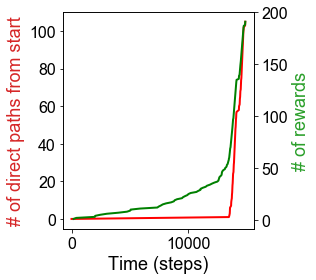

In [14]:
plot_graph_Qr(Gs[-1],vmax = rew, starts = [start], goals = [goal], save_name = "./plots/r5_l4_d3_tree_graph.pdf")

L = len(nx.shortest_path(G,start[0],goal[1]))-1
time_paths, cum_paths = get_direct_paths(time_rews,L)

plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (4.5,4))
axis.tick_params(labelsize = 16)
ax = axis.twinx()
ax.plot(time_rews, cum_rews,'g-', lw = 2)
ax.tick_params(labelsize = 16)
axis.plot(time_paths, cum_paths,'r-', lw = 2)
axis.set_ylabel("# of direct paths from start", fontsize= 18, color = 'C3')
ax.set_ylabel("# of rewards", fontsize= 18, color = 'C2')
axis.set_xlabel("Time (steps)", fontsize= 18)
fig.tight_layout()
fig.savefig("./plots/r5_l4_d3_tree_curve.pdf")
plt.show()

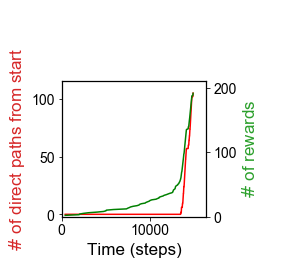

In [45]:
L = len(get_nodes_from_start_to_goal(start[0],goal[-1])) - 1
time_paths, cum_paths = get_direct_paths(time_rews,L)

name_prefix = "movie_r%d_l%d_d%d_tree/movie_r%d_l%d_d%d" %(int(rew),levels,degree,int(rew),levels,degree)
create_pngs_for_movie(Gs[:],[start],[goal],time_rews,cum_rews,L,rew, name_prefix)

In [314]:
ffmpeg -framerate 30 -pattern_type glob -i 'movie_r5_l4_d3_curve_*.png' -c:v h264 -pix_fmt yuv420p -allow_sw 1 -vb 20M curve.mp4
ffmpeg -framerate 30 -pattern_type glob -i 'movie_r5_l4_d3_graph_*.png' -c:v h264 -pix_fmt yuv420p -vb 20M graph.mp4
ffmpeg -i graph.mp4 -i curve.mp4 -filter_complex hstack=inputs=2 -vb 20M final.mp4

## Tree with levels = 4, degree = 2 turn-back = True

In [46]:
np.random.seed(0)

alpha = 0.1
gam = 1
goal = ('r011','r0111')
start = ('r1001','r100')

niter = 500
nepi = 150
lamb = 0.0 
mode = 2

rew = 5
levels = 4
degree = 2
turn_back = True

#generate graph and get Q values
G = create_tree_directed(levels, degree)
Tmat = get_transition_matrix_tree(levels,degree)
G = initialize_Q_tree(G,degree, turn_back=turn_back)

nodes,time_rews,cum_rews,Gs = run_RL_simulation(G,Tmat,[start],goal,nepi,niter,0,lamb = lamb,\
                                        renew = False,alpha = alpha,gam=gam,rew = rew,mode=mode)

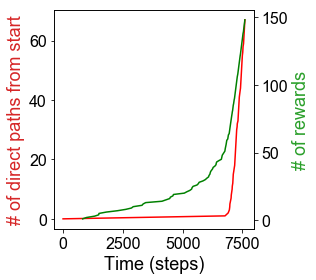

In [47]:
plot_graph_Qr(Gs[-1],vmax = rew, starts = [start], goals = [goal], save_name = "./plots/r5_l4_d2_tb_tree_graph.pdf")

L = len(nx.shortest_path(G,start[0],goal[1]))-1
time_paths, cum_paths = get_direct_paths(time_rews,L)

plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (4.5,4))
axis.tick_params(labelsize = 16)
ax = axis.twinx()
ax.plot(time_rews, cum_rews,'g-', lw = 2)
ax.tick_params(labelsize = 16)
axis.plot(time_paths, cum_paths,'r-', lw = 2)
axis.set_ylabel("# of direct paths from start", fontsize= 18, color = 'C3')
ax.set_ylabel("# of rewards", fontsize= 18, color = 'C2')
axis.set_xlabel("Time (steps)", fontsize= 18)
fig.tight_layout()
fig.savefig("./plots/r5_l4_d2_tb_tree_curve.pdf")
plt.show()

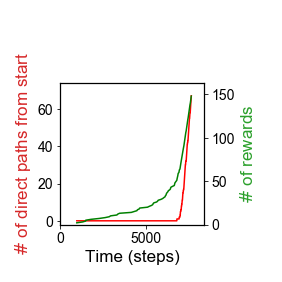

In [48]:
L = len(get_nodes_from_start_to_goal(start[0],goal[-1])) - 1
time_paths, cum_paths = get_direct_paths(time_rews,L)

name_prefix = "movie_r%d_l%d_d%d_tree/movie_r%d_l%d_d%d" %(int(rew),levels,degree,int(rew),levels,degree)
create_pngs_for_movie(Gs[:],[start],[goal],time_rews,cum_rews,L,rew, name_prefix)

In [ ]:
ffmpeg -framerate 30 -pattern_type glob -i 'movie_r5_l4_d2_curve_*.png' -c:v h264 -pix_fmt yuv420p -allow_sw 1 -vb 20M curve.mp4
ffmpeg -framerate 30 -pattern_type glob -i 'movie_r5_l4_d2_graph_*.png' -c:v h264 -pix_fmt yuv420p -vb 20M graph.mp4
ffmpeg -i graph.mp4 -i curve.mp4 -filter_complex hstack=inputs=2 -vb 20M final.mp4

## Manhattan graph (6,6) 

In [72]:
# Manhattan graph
    
def create_manhattan_graph(length,width):
    G = nx.DiGraph()
    edges = []
    for l in range(length):
        for w in range(width-1):
            node1 = (l,w)
            node2 = (l,w+1)
            edges += [(node1,node2)]
            
    for l in range(length-1):
        for w in range(width):
            node1 = (l,w)
            node2 = (l+1,w)
            edges += [(node1,node2)]
            
    node1 = 's'
    node2 = (0,0)
    edges += [(node1,node2)]
    node1 = 'g'
    node2 = (length-1,width-1)
    edges += [(node1,node2)]
    
    G = add_diedges_to_graph(G,edges)
    
    return G

def get_transition_matrix_manhattan(length,width):
    G = create_manhattan_graph(length,width)
    index_to_state = get_index_to_state_vec(G)
    S = len(index_to_state)
    A = 4 #NESW
    Tmat = np.zeros((S,A,S)) + 1e-6 #add small constant to avoid dividing by zero downstream. 
    for s in range(S):
        state = index_to_state[s]
        n1 = state[0]
        n2 = state[1]
        for a in range(A):
            if n2 == 's':
                n3 = (0,0)
            elif n2 == 'g':
                n3 = (length-1,width-1)
            else:
                if a == 0: #north
                    if n2[0] == length - 1 and n2[1] == width - 1: #to start
                        n3 = 'g'
                    elif n2[0] + 1 > length-1:
                        if n1 == 'g':
                            n3 = 'g'
                        else:
                            n3 = (n2[0] - 1,n2[1])
                    else:
                        n3 = (n2[0] + 1,n2[1])

                elif a == 1: #east
                    if n2[1] + 1 > width-1:
                        if n1 == 'g':
                            n3 = 'g'
                        else:
                            n3 = (n2[0],n2[1]-1)
                    else:
                        n3 = (n2[0],n2[1]+1)

                elif a == 2: #south
                    if n2[0] == 0 and n2[1] == 0: #to start
                        n3 = 's'
                    elif n2[0] - 1 < 0:
                        if n1 == 's':
                            n3 = 's'
                        else:
                            n3 = (n2[0]+1,n2[1])
                    else:
                        n3 = (n2[0]-1,n2[1]) 

                elif a == 3: #west
                    if n2[1] - 1 < 0:
                        if n1 == 's':
                            n3 = 's'
                        else:
                            n3 = (n2[0],n2[1]+1)
                    else:
                        n3 = (n2[0],n2[1]-1)   
                    
            
            nextstate = (n2,n3)
            nextstate_index = get_state_index(nextstate,G)
            Tmat[s,a,nextstate_index] = 1
            
    Tmat /= np.sum(Tmat,axis=-1)[:,:,None]
    return Tmat 

def initialize_Q_manhattan(G,turn_back = False): #set exploration probabilities via Qe
    
    index_to_state = get_index_to_state_vec(G)
    
    S = len(index_to_state)
    A = 4 #NESW
    
    if turn_back:
        qe_back = 0
    else:
        qe_back = -10
    
    for s in range(S):
        state = index_to_state[s]
        n1 = state[0]
        n2 = state[1]
        
        G[state[0]][state[1]]['Qr'] = np.zeros(A)
        G[state[0]][state[1]]['Qe'] = np.zeros(A)
        
        
        #at start and goal
        if n2 == 's':
            G[state[0]][state[1]]['Qe'][1] = -10
            G[state[0]][state[1]]['Qe'][2] = -10
            G[state[0]][state[1]]['Qe'][3] = -10
            continue
        if n2 == 'g':
            G[state[0]][state[1]]['Qe'][1] = -10
            G[state[0]][state[1]]['Qe'][2] = -10
            G[state[0]][state[1]]['Qe'][3] = -10
            continue
            
        if n1 == 's':
            G[state[0]][state[1]]['Qe'][3] = -10
            G[state[0]][state[1]]['Qe'][2] = qe_back
            continue
        if n1 == 'g':
            G[state[0]][state[1]]['Qe'][1] = -10
            G[state[0]][state[1]]['Qe'][0] = qe_back
            continue
            
        #agent cannot go off boundaries
        if n2[0] == length - 1:
            G[state[0]][state[1]]['Qe'][0] = -10
        if n2[0] == 0:
            G[state[0]][state[1]]['Qe'][2] = -10
        if n2[1] == width - 1:
            G[state[0]][state[1]]['Qe'][1] = -10
        if n2[1] == 0:
            G[state[0]][state[1]]['Qe'][3] = -10
        #except at start and goal
        if n2[0] == length - 1 and n2[1] == width - 1: 
            G[state[0]][state[1]]['Qe'][0] = 0
        if n2[0] == 0 and n2[1] == 0:
            G[state[0]][state[1]]['Qe'][2] = 0
            
        #turning back is prohibited
        if n1 != 's' and n1 != 'g':
            if n2[0] == n1[0] + 1:
                G[state[0]][state[1]]['Qe'][2] = qe_back
            if n2[0] == n1[0] - 1:
                G[state[0]][state[1]]['Qe'][0] = qe_back 
            if n2[1] == n1[1] + 1:
                G[state[0]][state[1]]['Qe'][3] = qe_back
            if n2[1] == n1[1] - 1:
                G[state[0]][state[1]]['Qe'][1] = qe_back         
        
    return G

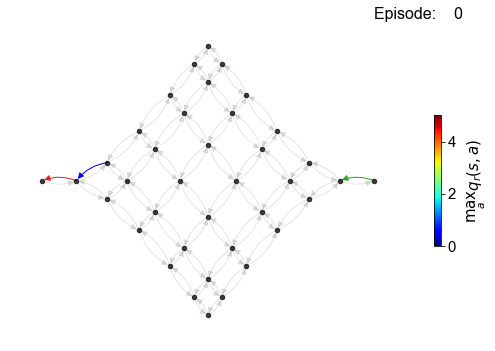

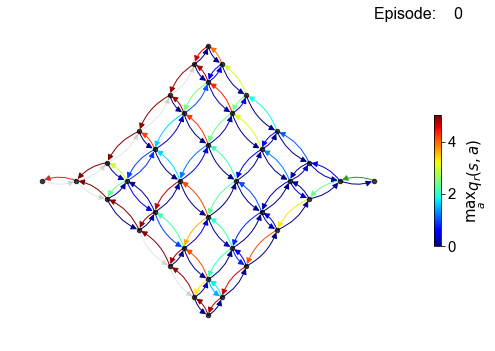

In [73]:
np.random.seed(1)

alpha = 0.1
gam = 1

niter = 500
nepi = 400
lamb = 0.0 
mode = 2

rew = 5
length = 6
width  = 6

start= ('s',(0,0))
goal = ((length-1,width-1),'g')

G = create_manhattan_graph(length,width)
Tmat = get_transition_matrix_manhattan(length,width)
G = initialize_Q_manhattan(G)

nodes,time_rews,cum_rews,Gs = run_RL_simulation(G,Tmat,[start],goal,nepi,niter,0,lamb = lamb,\
                                             renew = False,alpha = alpha,gam=gam,rew = rew,mode=mode)



plot_graph_Qr(Gs[0], episode = 0, vmax = rew, starts = [start], goals = [goal],style = 'spectral', figsize = (9,6))
plot_graph_Qr(Gs[-1], episode = 0, vmax = rew, starts = [start], goals = [goal],style = 'spectral', figsize = (9,6))


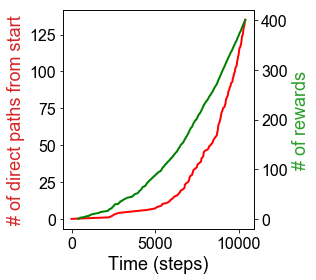

In [74]:
L = length + width
time_paths, cum_paths = get_direct_paths(time_rews,L)

plot_graph_Qr(Gs[-1],vmax = rew, starts = [start], goals = [goal] , style = 'spectral', figsize = (9,6),\
              save_name = "./plots/r5_l6_w6_man_graph.pdf")

plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (4.5,4))
axis.tick_params(labelsize = 16)
ax = axis.twinx()
ax.plot(time_rews, cum_rews,'g-', lw = 2)
ax.tick_params(labelsize = 16)
axis.plot(time_paths, cum_paths,'r-', lw = 2)
axis.set_ylabel("# of direct paths from start", fontsize= 18, color = 'C3')
ax.set_ylabel("# of rewards", fontsize= 18, color = 'C2')
axis.set_xlabel("Time (steps)", fontsize= 18)
fig.tight_layout()
fig.savefig("./plots/r5_l6_w6_man_curve.pdf")
plt.show()

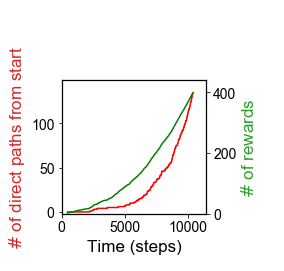

In [52]:
L = length + width

name_prefix = "movie_r%d_l%d_w%d_man/movie_r%d_l%d_w%d" %(int(rew),length,width,int(rew),length,width)
create_pngs_for_movie(Gs[:],[start],[goal],time_rews,cum_rews,L,rew, name_prefix, style = 'spectral',figsize = (9,6))

In [ ]:
ffmpeg -framerate 30 -pattern_type glob -i 'movie_r5_l6_w6_curve_*.png' -c:v h264 -pix_fmt yuv420p -allow_sw 1 -vb 20M curve.mp4
ffmpeg -framerate 30 -pattern_type glob -i 'movie_r5_l6_w6_graph_*.png' -c:v h264 -pix_fmt yuv420p -vb 20M graph.mp4
cd

## Random graphs 

In [4]:
def create_random_graph(n,p, seed = 0):
    G = nx.gnp_random_graph(n,p, seed = seed)
    idx = 0
    while not nx.is_connected(G) and idx < 20:
        G = nx.gnp_random_graph(n,p)
        idx += 1
        if idx > 19:
            print("connected graph not found")
            return 0

    edges = list(G.edges())
    
    dists = np.zeros((n,n))
    lens = list(nx.all_pairs_shortest_path_length(G))
    for i in range(n):
        for j in lens[i][1]:
            dists[i,j] = lens[i][1][j]
            
    
    inds = np.unravel_index(np.argmax(dists),dists.shape)
    
    print(inds)
    
    edges += [('s',inds[0])]
    edges += [('g',inds[1])]
    
    Gp = nx.DiGraph()
    Gp = add_diedges_to_graph(Gp,edges)
    
    return Gp

def get_transition_matrix_random(n,p, G = None):
    if G is None:
        G = create_random_graph(n,p)
    index_to_state = get_index_to_state_vec(G)
    S = len(index_to_state)
    degrees = [val/2 for (node, val) in G.degree()]
    
    A = int(np.max(degrees))
    
    Tmat = np.zeros((S,A,S)) + 1e-6 #add small constant to avoid dividing by zero downstream. 
    for s in range(S):
        state = index_to_state[s]
        n1 = state[0]
        n2 = state[1]
        for a in range(A):
            deg = G.degree[n2]/2
            
            if a > deg - 1:
                n3 = n1
            #print(list(nx.neighbors(G,n2)), a, deg)
            else:
                n3 = list(nx.neighbors(G,n2))[a]
            
            nextstate = (n2,n3)
            nextstate_index = get_state_index(nextstate,G)
            Tmat[s,a,nextstate_index] = 1
            
    Tmat /= np.sum(Tmat,axis=-1)[:,:,None]
    return Tmat 

def initialize_Q_random(G,turn_back = False): #set exploration probabilities via Qe
    index_to_state = get_index_to_state_vec(G)
    
    S = len(index_to_state)
    degrees = [val/2 for (node, val) in G.degree()]
    A = int(np.max(degrees))
    
    if turn_back:
        qe_back = 0
    else:
        qe_back = -10
    
    for s in range(S):
        state = index_to_state[s]
        n1 = state[0]
        n2 = state[1]
        
        G[state[0]][state[1]]['Qr'] = np.zeros(A)
        G[state[0]][state[1]]['Qe'] = np.zeros(A)
        
        deg = G.degree[n2]/2
        for a in range(A):
            if a > deg - 1:
                G[state[0]][state[1]]['Qe'][a] = -10
                
            elif list(nx.neighbors(G,n2))[a] == n1:
                G[state[0]][state[1]]['Qe'][a] = qe_back
              
    return G


(0, 16)
8


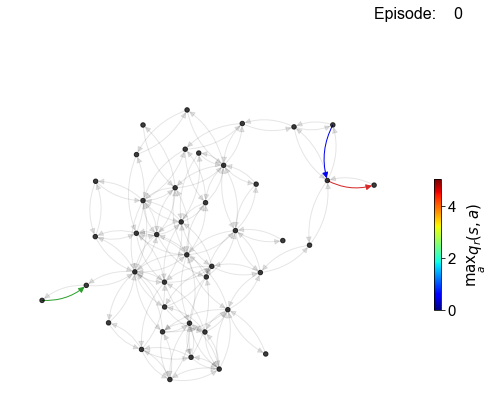

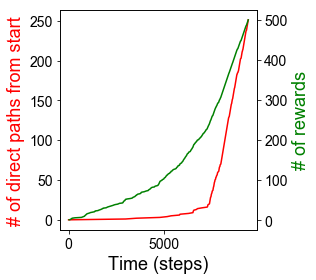

In [7]:
seed = 0
np.random.seed(seed)

alpha = 0.1
gam = 1

niter = 500
nepi = 500
lamb = 0.0 
mode = 2

rew = 5
n = 40
p = 0.08
turn_back = False

G = create_random_graph(n,p, seed = seed)

degrees = [val/2 for (node, val) in G.degree()]

goal = (list(nx.neighbors(G,'g'))[0],'g')
start = ('s',list(nx.neighbors(G,'s'))[0])

Tmat = get_transition_matrix_random(n,p, G = G)
G = initialize_Q_random(G, turn_back = turn_back)

nodes,time_rews,cum_rews,Gs = run_RL_simulation(G,Tmat,[start],goal,nepi,niter,0,lamb = lamb,\
                                             renew = False,alpha = alpha,gam=gam,rew = rew,mode=mode)
L = nx.diameter(Gs[0])
time_paths, cum_paths = get_direct_paths(time_rews,L)
print(L)

plot_graph_Qr(Gs[0], episode = 0, vmax = rew, starts = [start], goals = [goal], figsize = (9,6))
plot_graph_Qr(Gs[-1], episode = 0, vmax = rew, starts = [start], goals = [goal], figsize = (9,6), save_name= "./plots/random_graph_n%d_p%.2f_graph.pdf"%(n,p))

plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (4.5,4))
axis.tick_params(labelsize = 14)
ax = axis.twinx()
ax.plot(time_rews, cum_rews,'g-')
ax.tick_params(labelsize = 14)
axis.plot(time_paths, cum_paths,'r-')
axis.set_ylabel("# of direct paths from start", fontsize= 18, color = 'r')
ax.set_ylabel("# of rewards", fontsize= 18, color = 'g')
axis.set_xlabel("Time (steps)", fontsize= 18)
fig.tight_layout()
fig.savefig("./plots/random_graph_n%d_p%.2f_curve.pdf"%(n,p))
plt.show()

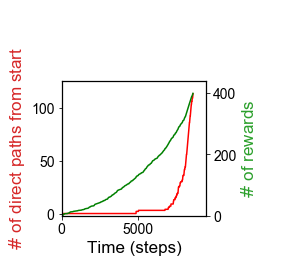

In [55]:
L = nx.diameter(Gs[0])
name_prefix = "movie_r%d_n%d_p%.2f_ran/movie_r%d_n%d_p%.2f" %(int(rew),n,p,int(rew),n,p)
create_pngs_for_movie(Gs[:],[start],[goal],time_rews,cum_rews,L,rew, name_prefix,figsize = (9,6))

In [226]:
ffmpeg -framerate 30 -pattern_type glob -i 'movie_r5_n40_p0.10_curve_*.png' -c:v h264 -pix_fmt yuv420p -allow_sw 1 -vb 20M curve.mp4
ffmpeg -framerate 30 -pattern_type glob -i 'movie_r5_n40_p0.10_graph_*.png' -c:v h264 -pix_fmt yuv420p -vb 20M graph.mp4
ffmpeg -i graph.mp4 -i curve.mp4 -filter_complex hstack=inputs=2 -vb 20M final.mp4

6
